<a href="https://colab.research.google.com/github/SamikshaSolanke/Deepfake-video-detection-CSI-Codezilla/blob/main/CSI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This file contains the code for training and saving the model

**For seeing the model 4, scroll down **

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

# Define paths
base_dir = '/content/drive/MyDrive/dataset_frames_2'
real_dir = os.path.join(base_dir, 'Celeb-real')
fake_dir = os.path.join(base_dir, 'Celeb-synthesis')

# Prepare an empty list to store labels
data = []

# Label real frames (0)
for folder in os.listdir(real_dir):
    frame_dir = os.path.join(real_dir, folder)
    if os.path.isdir(frame_dir):
        for frame in os.listdir(frame_dir):
            if frame.endswith('.jpg'):
                data.append([os.path.join(frame_dir, frame), 0])

# Label fake frames (1)
for folder in os.listdir(fake_dir):
    frame_dir = os.path.join(fake_dir, folder)
    if os.path.isdir(frame_dir):
        for frame in os.listdir(frame_dir):
            if frame.endswith('.jpg'):
                data.append([os.path.join(frame_dir, frame), 1])

# Convert to a DataFrame and save as CSV
df = pd.DataFrame(data, columns=['frame_path', 'label'])
df.to_csv('/content/drive/MyDrive/labels_frames_4.csv', index=False)

print("Labeling complete! CSV saved at /content/drive/MyDrive/labels_frames_4.csv")

Labeling complete! CSV saved at /content/drive/MyDrive/labels_frames_4.csv


**Importing a few important libraries and frameworks**

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

**Setting a few parameters**

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 10
LEARNING_RATE = 0.001

**Loading dataset and CSV file**

In [ ]:
csv_path = "/content/drive/MyDrive/labels_frames_4.csv"
base_dir = "/content/drive/MyDrive/dataset_frames_2"

data = pd.read_csv(csv_path)

**Splitting the dataset into training and validation**

In [ ]:
train_data = data.sample(frac=0.7, random_state=42)  # 70% for training
val_data = data.drop(train_data.index)  # Remaining 30% for validation

**Data generators for training and validation**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=20)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

**Data generators for training and validation**

In [ ]:
# Convert labels to strings
train_data['label'] = train_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col="frame_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col="frame_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 1862 validated image filenames belonging to 2 classes.
Found 798 validated image filenames belonging to 2 classes.


**Load pre-trained MobileNetV2 model + higher level layers**

In [ ]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")

**Freeze base model layers**

In [ ]:
base_model.trainable = False

**Add custom layers for binary classification(used in 1st and second model)**

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

**Add custom layers for binary classification(used 4th model)**

In [ ]:
x = base_model.output
avg_pool = GlobalAveragePooling2D()(x)
max_pool = GlobalMaxPooling2D()(x)
x = concatenate([avg_pool, max_pool])

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
#1st trained model on 560 imgs
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#2nd trained model on 798 imgs
model2 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#3rd model on 798 imgs
model3 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model(1st)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Compile the model(2nd)
model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Compile the model(3rd)
model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 290s 13s/step - accuracy: 0.4622 - loss: 0.8232 - val_accuracy: 0.5134 - val_loss: 0.7430
Epoch 2/7
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4375 - loss: 0.7150

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.4375 - loss: 0.7150 - val_accuracy: 0.2500 - val_loss: 0.8326
Epoch 3/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 333ms/step - accuracy: 0.5333 - loss: 0.6707 - val_accuracy: 0.5089 - val_loss: 0.7071
Epoch 4/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 0.7087 - val_accuracy: 0.5000 - val_loss: 0.6362
Epoch 5/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.6380 - loss: 0.6273 - val_accuracy: 0.5580 - val_loss: 0.7626
Epoch 6/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6250 - loss: 0.6599 - val_accuracy: 0.5000 - val_loss: 0.6883
Epoch 7/7
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 414ms/step - accuracy: 0.6013 - loss: 0.6276 - val_accuracy: 0.5446 - val_loss: 0.6808


In [ ]:
# Fine-tuning: Unfreeze some layers of the base model and train further
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10), loss="binary_crossentropy", metrics=["accuracy"])

# Train again for fine-tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)

Epoch 1/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 580ms/step - accuracy: 0.5397 - loss: 0.6905 - val_accuracy: 0.4969 - val_loss: 0.7019
Epoch 2/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5625 - loss: 0.6854 - val_accuracy: 0.4545 - val_loss: 0.7216
Epoch 3/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 434ms/step - accuracy: 0.5379 - loss: 0.6961 - val_accuracy: 0.5031 - val_loss: 0.6942
Epoch 4/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.6823 - val_accuracy: 0.6818 - val_loss: 0.6752
Epoch 5/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.5698 - loss: 0.6795 - val_accuracy: 0.4812 - val_loss: 0.6962
Epoch 6/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4375 - loss: 0.6766 - val_accuracy: 0.7273 - val_loss: 0.6508
Epoch 7/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.5575 - loss: 0.6729 - val_accuracy: 0.4750 - val_loss: 0.6963


In [ ]:
#2nd model
history_fine = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 395s 14s/step - accuracy: 0.5231 - loss: 0.7842 - val_accuracy: 0.5437 - val_loss: 0.6910
Epoch 2/7
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4062 - loss: 0.7537

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.4062 - loss: 0.7537 - val_accuracy: 0.5455 - val_loss: 0.7298
Epoch 3/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 433ms/step - accuracy: 0.5405 - loss: 0.7080 - val_accuracy: 0.4563 - val_loss: 0.7397
Epoch 4/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 0.7120 - val_accuracy: 0.5455 - val_loss: 0.7226
Epoch 5/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 0.5440 - loss: 0.6802 - val_accuracy: 0.5938 - val_loss: 0.6671
Epoch 6/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5667 - loss: 0.6090 - val_accuracy: 0.6364 - val_loss: 0.6481
Epoch 7/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.6039 - loss: 0.6411 - val_accuracy: 0.5094 - val_loss: 0.7145


In [ ]:
# Fine-tuning: Unfreeze some layers of the base model and train further
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10), loss="binary_crossentropy", metrics=["accuracy"])

# Train again for fine-tuning
history_fine = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)

Epoch 1/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - accuracy: 0.5989 - loss: 0.6408 - val_accuracy: 0.5875 - val_loss: 0.6583
Epoch 2/7
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6562 - loss: 0.5508

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6562 - loss: 0.5508 - val_accuracy: 0.5000 - val_loss: 0.6601
Epoch 3/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.6404 - loss: 0.6097 - val_accuracy: 0.5281 - val_loss: 0.6671
Epoch 4/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5625 - loss: 0.6417 - val_accuracy: 0.5455 - val_loss: 0.7204
Epoch 5/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 429ms/step - accuracy: 0.5946 - loss: 0.6290 - val_accuracy: 0.6031 - val_loss: 0.6585
Epoch 6/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 0.6632 - val_accuracy: 0.6364 - val_loss: 0.6185
Epoch 7/7
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 430ms/step - accuracy: 0.6112 - loss: 0.6263 - val_accuracy: 0.6000 - val_loss: 0.6536


In [ ]:
#3rd model
history_fine = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 268s 9s/step - accuracy: 0.5348 - loss: 0.8081 - val_accuracy: 0.4531 - val_loss: 2.5440
Epoch 2/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5625 - loss: 0.7794

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5625 - loss: 0.7794 - val_accuracy: 0.5455 - val_loss: 1.5247
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.5596 - loss: 0.7307 - val_accuracy: 0.4844 - val_loss: 0.8941
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4688 - loss: 0.8086 - val_accuracy: 0.5455 - val_loss: 0.6210
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5867 - loss: 0.7167 - val_accuracy: 0.4812 - val_loss: 0.9224
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5312 - loss: 0.8090 - val_accuracy: 0.5909 - val_loss: 0.7371
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5912 - loss: 0.6850 - val_accuracy: 0.5906 - val_loss: 0.8042
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.7188 - loss: 0.6341 - val_accuracy: 0.6364 - val_loss: 0.6647
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5741 - loss: 0.6833 - val_accuracy: 0.6031 - val_loss: 0.70

In [ ]:
# Fine-tuning: Unfreeze some layers of the base model and train further
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10), loss="binary_crossentropy", metrics=["accuracy"])

# Train again for fine-tuning
history_fine = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5786 - loss: 0.6683 - val_accuracy: 0.5594 - val_loss: 0.6949
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.5625 - loss: 0.6834 - val_accuracy: 0.5909 - val_loss: 0.7032
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.6055 - loss: 0.6481 - val_accuracy: 0.5094 - val_loss: 0.7358
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6250 - loss: 0.6225 - val_accuracy: 0.4091 - val_loss: 0.8344
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5922 - loss: 0.6693 - val_accuracy: 0.5188 - val_loss: 0.7332
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6250 - loss: 0.5765 - val_accuracy: 0.6364 - val_loss: 0.6371
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.6807 - loss: 0.5794 - val_accuracy: 0.5281 - val_loss: 0.7812
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7188 - loss: 0.6031 - val_accuracy: 0.5000 - val_

In [ ]:
# Convert to TensorFlow Lite for mobile integration
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the TFLite model
with open("/content/drive/MyDrive/deepfake_detector_model3.tflite", "wb") as f:
    f.write(tflite_model)

print("Model training and conversion completed successfully!")

Saved artifact at '/tmp/tmpm6omoaq2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134811480716592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017075392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017075920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017073632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017074512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134811480717472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017304592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017303712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017302656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134810017303888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13481001708612

In [ ]:
val_loss, val_accuracy = model3.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5530 - loss: 0.7674
Validation Loss: 0.7680073976516724
Validation Accuracy: 0.5380116701126099


In [ ]:
# Generate predictions
val_generator.reset()
predictions = model3.predict(val_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = val_generator.classes

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


In [ ]:
# Classification report
# Import the classification_report function
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=["Real", "Deepfake"], digits=4)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        Real     0.4789    0.8608    0.6154       158
    Deepfake     0.6207    0.1957    0.2975       184

    accuracy                         0.5029       342
   macro avg     0.5498    0.5282    0.4565       342
weighted avg     0.5552    0.5029    0.4444       342



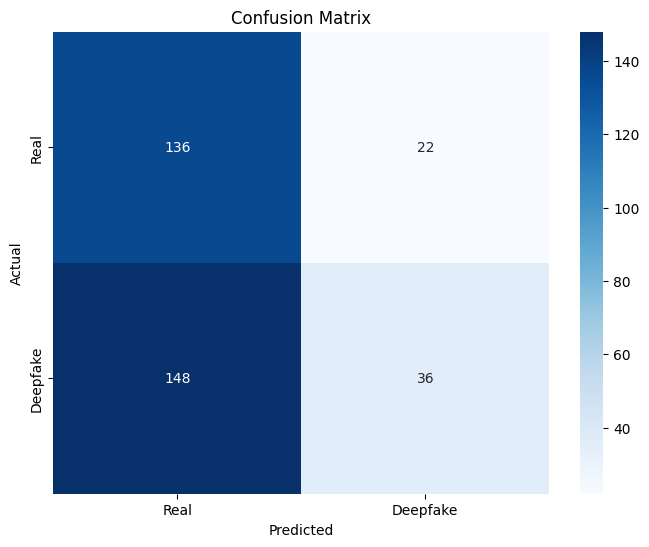

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Deepfake"], yticklabels=["Real", "Deepfake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Current Final Model Training

In [ ]:
#3rd model on 1862 imgs
model4 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model(3rd)
model4.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history_fine = model4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 396s 6s/step - accuracy: 0.5331 - loss: 0.9300 - val_accuracy: 0.5039 - val_loss: 1.0776
Epoch 2/10
 1/58 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.5000 - loss: 0.9302

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 806ms/step - accuracy: 0.5000 - loss: 0.9302 - val_accuracy: 0.6333 - val_loss: 1.1039
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.5585 - loss: 0.7798 - val_accuracy: 0.5104 - val_loss: 0.9748
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3438 - loss: 0.9485 - val_accuracy: 0.5000 - val_loss: 1.0917
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.5587 - loss: 0.7113 - val_accuracy: 0.5951 - val_loss: 0.7370
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7188 - loss: 0.5223 - val_accuracy: 0.4333 - val_loss: 0.8515
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.5423 - loss: 0.7491 - val_accuracy: 0.5065 - val_loss: 0.7279
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5938 - loss: 0.7312 - val_accuracy: 0.5333 - val_loss: 0.7821
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.5968 - loss: 0.6805 - val_accuracy: 0.5482 - val_loss: 

In [ ]:
# Fine-tuning: Unfreeze some layers of the base model and train further
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

model4.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10), loss="binary_crossentropy", metrics=["accuracy"])

# Train again for fine-tuning
history_fine = model4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_steps=val_generator.n // BATCH_SIZE
)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.5377 - loss: 0.7284 - val_accuracy: 0.5234 - val_loss: 0.7837
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5938 - loss: 0.6507 - val_accuracy: 0.5000 - val_loss: 0.8574
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.6252 - loss: 0.6348 - val_accuracy: 0.5833 - val_loss: 0.7077
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6250 - loss: 0.6509 - val_accuracy: 0.5667 - val_loss: 0.7617
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.6706 - loss: 0.5804 - val_accuracy: 0.6380 - val_loss: 0.6496
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5625 - loss: 0.7161 - val_accuracy: 0.5667 - val_loss: 0.6989
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7034 - loss: 0.5588 - val_accuracy: 0.5924 - val_loss: 0.7926
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6875 - loss: 0.6625 - val_accuracy: 0.6000 - v

In [ ]:
# Convert to TensorFlow Lite for mobile integration
converter = tf.lite.TFLiteConverter.from_keras_model(model4)
tflite_model = converter.convert()

# Save the TFLite model
with open("/content/drive/MyDrive/deepfake_detector_model4.tflite", "wb") as f:
    f.write(tflite_model)

print("Model training and conversion completed successfully!")

Saved artifact at '/tmp/tmpychexv37'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_166')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134812523994224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134812310916080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809612543152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809535970496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809535757328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809535962224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809536107040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809536116016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809536112496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134809536118304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1348095361

In [ ]:
val_loss, val_accuracy = model3.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.5674 - loss: 0.8754
Validation Loss: 0.8466735482215881
Validation Accuracy: 0.5751879811286926


In [ ]:
# Generate predictions
val_generator.reset()
predictions = model3.predict(val_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = val_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step


In [ ]:
# Classification report
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=["Real", "Deepfake"], digits=4)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        Real     0.5143    0.8609    0.6439       417
    Deepfake     0.4200    0.1102    0.1746       381

    accuracy                         0.5025       798
   macro avg     0.4672    0.4856    0.4093       798
weighted avg     0.4693    0.5025    0.4199       798



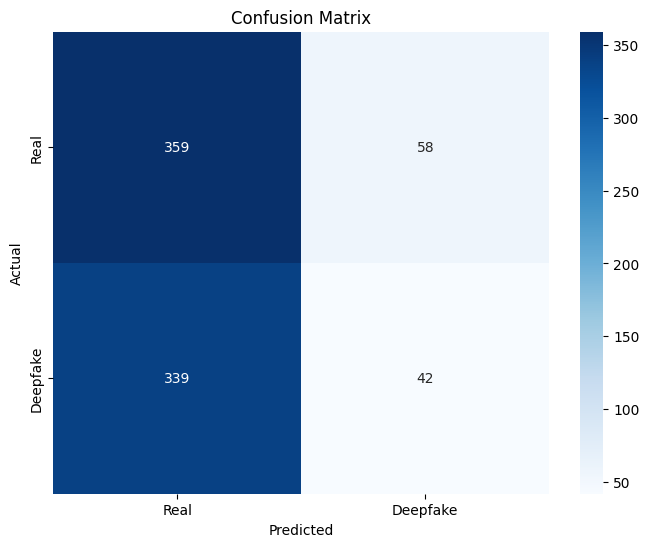

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Deepfake"], yticklabels=["Real", "Deepfake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()